In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


* age — возраст основного бенефициара;
* sex — пол страхового подрядчика;
* bmi — индекс массы тела (кгм), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

In [3]:
print(data.shape)

(1338, 7)


In [4]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [7]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [8]:
from sklearn.model_selection import train_test_split
#Разделяем выборку на тренировочную и тестовую в соотношении 70/30
#Устанавливаем random_state для воспроизводимости результатов 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Выводим результирующие размеры таблиц
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (1070, 9) (1070,)
Test: (268, 9) (268,)


In [16]:
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X_train, y_train)

# Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
# Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(round(coef_df,2))

,Features,Coefficients
0,age,256.98
1,sex,-18.59
2,bmi,337.09
3,children,425.28
4,smoker,23651.13
5,region_northeast,459.59
6,region_northwest,88.91
7,region_southeast,-198.28
8,region_southwest,-350.21
9,INTERCEPT,-12390.80


In [26]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.4f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [20]:
#Делаем предсказание для каждой из выборок
y_train_pred = lr_full.predict(X_train)
y_test_pred = lr_full.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


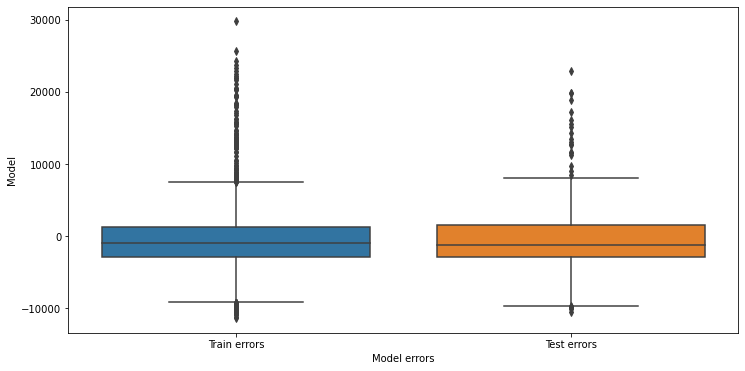

In [21]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
# Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [22]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [27]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2916.301
Train MAPE: 29.855


Test R^2: 0.8666
Test MAE: 2754.796
Train MAPE: 30.751


In [34]:
print(np.round(lr_poly.coef_, 3))

[-3.59237378e+16  2.08107466e+17  3.19105246e+15  2.97252211e+15
 -4.99707551e+15 -6.51521885e+15  9.96211525e+15  1.82743587e+16
  2.19939866e+15  8.38400000e+03  8.32000000e+02  8.66000000e+02
 -1.79400000e+03  1.54000000e+02  3.59237378e+16  3.59237378e+16
  3.59237378e+16  3.59237378e+16 -1.84771151e+17  6.42750000e+02
 -1.25050000e+03  2.59125000e+02 -2.33363150e+16 -2.33363150e+16
 -2.33363150e+16 -2.33363150e+16 -9.61050000e+03  1.57678100e+03
  5.48170780e+04 -3.19105246e+15 -3.19105246e+15 -3.19105246e+15
 -3.19105246e+15 -2.00000000e+03 -2.21200000e+03 -2.97252211e+15
 -2.97252211e+15 -2.97252211e+15 -2.97252211e+15 -7.67009066e+15
  1.26671662e+16  1.26671662e+16  1.26671662e+16  1.26671662e+16
  1.45277359e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.94959824e+15  0.00000000e+00  0.00000000e+00 -1.02618417e+16
  0.00000000e+00  5.81311836e+15]


In [38]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
print('-------')
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Test R^2: 0.867
-------
Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.8668
Test MAE: 2719.334
Train MAPE: 30.070


In [39]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge() # alpha=10
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
print('-------')
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.839
Test R^2: 0.863
-------
Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.8633
Test MAE: 2860.555
Train MAPE: 31.380
